In [1]:
%load_ext autoreload
%autoreload 2
from pkg.forecast import SalesForecast
from pkg.sales_forecasting import SalesForecasting
import pandas as pd
import numpy as np

Importing plotly failed. Interactive plots will not work.


In [2]:
self = SalesForecasting('1403Q3')
sale_df_total = self.load_sales_data()
forecast_df = self.load_forecast_data()
sale_df_total['date'] = sale_df_total['date'].astype('int32')
products_fr = pd.unique(forecast_df['product'])
products = pd.unique(sale_df_total['product'])
sale_df_total.date += 62100

In [7]:
product = 'Lumista'
sale_df = sale_df_total[sale_df_total['product'] == product]
forecasts = 'data/results/1403Q3/1403Q3_total_forecast.csv'
prod_fr = SalesForecast(product, sale_df, forecasts)
prod_fr.preprocess_data()

In [8]:
prod_fr.model_selection()
prod_fr.predict()
prod_fr.redistribute_smoothing()

1/1 [==============================] - 0s 19ms/step


c:\Users\Mohajeri.K\AppData\Local\anaconda3\envs\forecast\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
c:\Users\Mohajeri.K\AppData\Local\anaconda3\envs\forecast\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


In [5]:
prod_fr.redistribute_smoothing()
prod_fr.save_csv()

Ablyze forecasting is done!


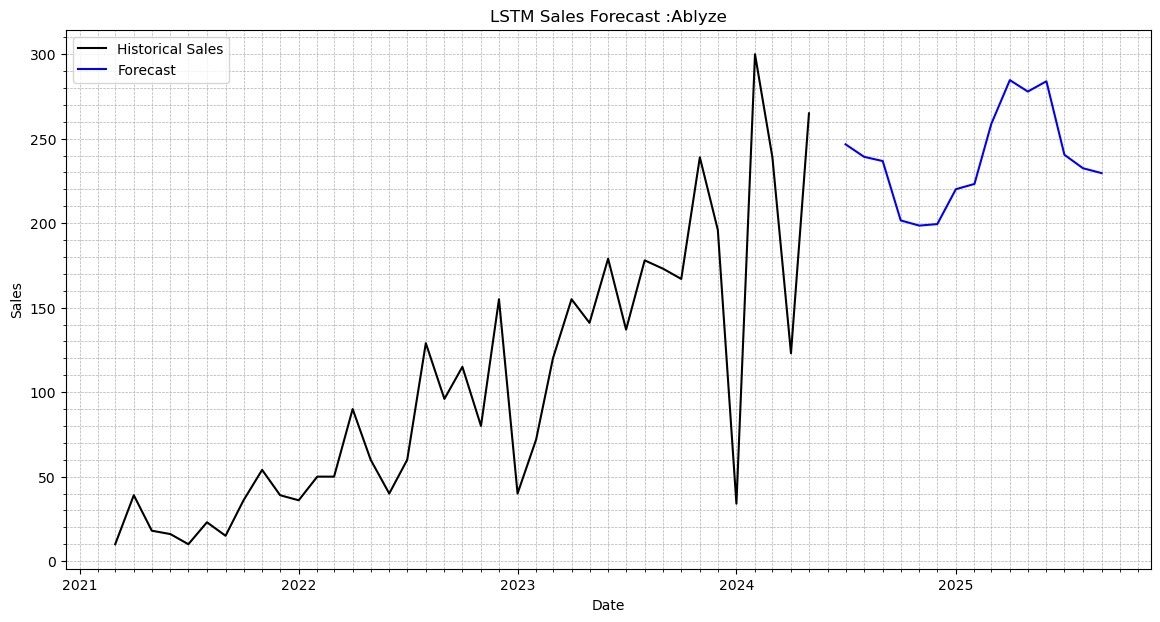

In [9]:
prod_fr.plot()

In [ ]:
x = prod_fr.scaler_minmax.inverse_transform(
            pd.DataFrame(prod_fr.forecast))
x = (x.cumsum()) + prod_fr.last_sale
x = prod_fr.transformer_yeo.inverse_transform(x.reshape(-1,1))

array([ 0.17419414, -0.03541802,  0.18335082,  0.08938788,  0.08661168,
        0.2590314 , -0.00536305, -0.53571857,  0.89906229, -0.16204508,
       -0.33587796,  0.263705  ,  0.17419414, -0.03541802,  0.18335082])

In [6]:
pd.DataFrame(sale_df.groupby(['date'])['sales'].sum())

,sales
date,
2021-03-01,10.0
2021-04-01,39.0
2021-05-01,18.0
2021-06-01,16.0
2021-07-01,10.0
2021-08-01,23.0
2021-09-01,15.0
2021-10-01,36.0
2021-11-01,54.0


In [9]:
len(prod_fr.sale_df['sales'].diff().dropna())

39

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
def ml_window(sequences, look_back=12):
    X, y = [], []
    for i in range(len(sequences)-look_back):
        x = sequences.iloc[i:(i+look_back)]
        X.append(x)
        y.append(sequences.iloc[i + look_back])
    return np.array(X), np.array(y)

In [ ]:
look_back = 3
train_ratio = 0.8
train_size = int(train_ratio * len(prod_fr.sale_series))
X, y = ml_window(pd.DataFrame(prod_fr.sale_series), look_back)
X_train, X_test = X[:train_size-look_back], X[train_size-look_back:]
y_train, y_test = y[:train_size-look_back], y[train_size-look_back:]
model = Sequential(
    [
        LSTM(128, activation='tanh', return_sequences=True, input_shape=(look_back, 1)),
        LSTM(64, activation='tanh', return_sequences=False),
        Dense(1)
    ]
)
model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mape'])
model.fit(x=X_train, y=y_train, epochs=100, verbose=2)
predictions = np.zeros(len(X_test))
for i in range(len(X_test)):
    predictions[i] = model.predict(X_test[i].reshape(1, look_back, 1))
    if i != len(X_test)-1:
        X_test[i+1,look_back-1] = predictions[i]
        for j in range(look_back-1):
            X_test[i+1,j] = X_test[i,j+1]
# forecasts = model.predict(X_test)
rmse = sqrt(mean_squared_error(y_test, predictions))
rmse

Epoch 1/100
1/1 - 3s - loss: 0.1069 - mape: 97.5347 - 3s/epoch - 3s/step
Epoch 2/100
1/1 - 0s - loss: 0.1019 - mape: 97.3926 - 6ms/epoch - 6ms/step
Epoch 3/100
1/1 - 0s - loss: 0.0971 - mape: 97.2815 - 5ms/epoch - 5ms/step
Epoch 4/100
1/1 - 0s - loss: 0.0926 - mape: 97.2736 - 5ms/epoch - 5ms/step
Epoch 5/100
1/1 - 0s - loss: 0.0883 - mape: 97.4238 - 6ms/epoch - 6ms/step
Epoch 6/100
1/1 - 0s - loss: 0.0842 - mape: 100.0173 - 9ms/epoch - 9ms/step
Epoch 7/100
1/1 - 0s - loss: 0.0805 - mape: 104.1625 - 11ms/epoch - 11ms/step
Epoch 8/100
1/1 - 0s - loss: 0.0771 - mape: 108.8982 - 0s/epoch - 0s/step
Epoch 9/100
1/1 - 0s - loss: 0.0743 - mape: 114.3158 - 7ms/epoch - 7ms/step
Epoch 10/100
1/1 - 0s - loss: 0.0722 - mape: 120.5171 - 5ms/epoch - 5ms/step
Epoch 11/100
1/1 - 0s - loss: 0.0710 - mape: 128.7120 - 7ms/epoch - 7ms/step
Epoch 12/100
1/1 - 0s - loss: 0.0708 - mape: 138.4433 - 6ms/epoch - 6ms/step
Epoch 13/100
1/1 - 0s - loss: 0.0711 - mape: 150.1901 - 7ms/epoch - 7ms/step
Epoch 14/100
1/

0.8369620896375607

In [ ]:
prod_fr.trans_flag

2

In [ ]:
X_test[0].reshape(1, look_back, 1)

array([[[0.72350112],
        [0.75756241],
        [0.60431407]]])

In [ ]:
# forecasts = np.concatenate(prod_fr[0], forecasts).cumsum() 
# forecasts = scaler.inverse_transform(pd.DataFrame(forecasts))
# y_test = scaler.inverse_transform(pd.DataFrame(y_test))
# forecasts = inv_boxcox(forecasts, lam)
# y_test = inv_boxcox(y_test, lam)


In [ ]:
list(y_test.reshape(-1,))

[0.5518575851393189, 0.9690402476780186]

In [ ]:
prod_fr.forecast
# prod_fr.plot()

array([[ 936.87302828],
       [1006.070647  ],
       [1081.22931695],
       [1017.19062161],
       [1039.10459089],
       [1048.37765384],
       [1037.76193547],
       [1043.23058987],
       [1044.17633986],
       [1042.63014913],
       [1043.87292361],
       [1043.94870067],
       [1043.78051257],
       [1044.05512738],
       [1044.06606269]])

In [ ]:
prod_fr.sale_df

,date,sales
0,2023-08-01,0.193498
1,2023-09-01,0.431115
2,2023-10-01,0.587461
3,2023-11-01,0.759288
4,2023-12-01,0.839009
5,2024-01-01,0.253096
6,2024-02-01,1.000000
7,2024-03-01,0.506192
8,2024-04-01,0.551858
9,2024-05-01,0.969040


In [ ]:
prod_fr.predict()

In [ ]:
prod_fr.actuals

[0.22303349197434155, 0.11639421797865736, 0.11023086700759703]

In [ ]:
sale_df

,product_fa,product,date,provider,dep,boxq,sales
4395,برکسورف 8,Beraksurf 8,2019-10-01,پرسیس ژن,رسپیراتوری,1.0,15.0
4396,برکسورف 8,Beraksurf 8,2019-11-01,پرسیس ژن,رسپیراتوری,1.0,180.0
4397,برکسورف 8,Beraksurf 8,2019-12-01,پرسیس ژن,رسپیراتوری,1.0,40.0
4398,برکسورف 8,Beraksurf 8,2020-01-01,پرسیس ژن,رسپیراتوری,1.0,25.0
4399,برکسورف 8,Beraksurf 8,2020-02-01,پرسیس ژن,رسپیراتوری,1.0,63.0
...,...,...,...,...,...,...,...
4477,برکسورف 8,Beraksurf 8,2024-04-01,پرسیس ژن,رسپیراتوری,NaN,0.0
4478,برکسورف 8,Beraksurf 8,2024-05-01,پرسیس ژن,رسپیراتوری,1.0,1031.0
4479,برکسورف 8,Beraksurf 8,2024-05-01,پرسیس ژن,رسپیراتوری,NaN,0.0
4480,برکسورف 8,Beraksurf 8,2024-06-01,پرسیس ژن,رسپیراتوری,1.0,10.0


In [ ]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(prod_fr.sale_df['sales'])

In [ ]:
result

(-3.0567582447682757,
 0.02992322120792008,
 0,
 35,
 {'1%': -3.6327426647230316,
  '5%': -2.9485102040816327,
  '10%': -2.6130173469387756},
 -4.257162619800816)

In [ ]:
prod_fr.sale_df[:-1]['sales']

0     0.034130
1     0.266212
2     0.904437
3     0.637088
4     0.045506
5     0.022753
6     0.000000
7     0.290102
8     0.602958
9     0.980660
10    0.434585
11    0.333333
12    0.205916
13    0.637088
14    1.000000
15    0.707622
Name: sales, dtype: float64

In [ ]:
prod_fr.trans_flag

0

In [ ]:
prod_fr.forecast

array([[1201.17744878],
       [1209.66570353],
       [1218.15395829],
       [1226.64221304],
       [1235.13046779],
       [1243.61872254],
       [1252.1069773 ],
       [1260.59523205],
       [1269.0834868 ],
       [1277.57174155],
       [1286.0599963 ],
       [1294.54825106],
       [1303.03650581],
       [1311.52476056],
       [1320.01301531]])

In [ ]:
X_test[0, -1, 0]

0.5118592195868401

In [ ]:
X_test.shape

(2, 3, 1)

In [ ]:
y_test.iloc[-2:-1]

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [ ]:
arr = np.array([1, 2, 3, 4, 5, 6, 7])

print(arr[-3:-1]) 

[5 6]


In [ ]:
l = len(prod_fr.sale_series)

In [ ]:
pr=np.array([])

In [ ]:
predict = prod_fr.sale_series.iloc[l-look_back:]

In [ ]:
pr = np.append(pr, predict)

In [ ]:
predict

date
2024-03-01    0.511859
2024-04-01    0.557001
2024-05-01    0.969396
Freq: MS, Name: sales, dtype: float64

In [ ]:
predictions = []
current_input = np.array(prod_fr.sale_series[-look_back:]).reshape((1, look_back, 1))
for _ in range(15):
    next_pred = model.predict(current_input)
    predictions.append(next_pred[0, 0])
    current_input = np.append(current_input[:, 1:, :], [next_pred], axis=1)

1/1 [==============================] - 0s 32ms/step


In [ ]:
predictions

[0.61175835,
 0.64712864,
 0.68320817,
 0.62728727,
 0.6349555,
 0.6359864,
 0.6267459,
 0.6278379,
 0.62710434,
 0.62550217,
 0.6255526,
 0.6252519,
 0.62495106,
 0.624915,
 0.62482667]

In [ ]:
np.append(current_input[:, 1:, :], [next_pred], axis=1)

array([[[0.55700077],
        [0.96939556],
        [0.61175835]]])

In [ ]:
prod_fr.forecast_index

DatetimeIndex(['2024-08-01', '2024-09-01', '2024-10-01', '2024-11-01',
               '2024-12-01', '2025-01-01', '2025-02-01', '2025-03-01',
               '2025-04-01', '2025-05-01', '2025-06-01', '2025-07-01',
               '2025-08-01', '2025-09-01', '2025-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [ ]:
a = pd.Series([1, 2, 3])
b = pd.Series([4, 5, 6])
pd.concat([a, b])

0    1
1    2
2    3
0    4
1    5
2    6
dtype: int64

In [ ]:
pd.Series(prod_fr.sale_series.flat, index=prod_fr.sale_df.date[:-1])

date
2013-11-01   -2.376695
2013-12-01   -0.115307
2014-01-01   -0.008445
2014-02-01    0.759942
2014-03-01   -0.078195
                ...   
2024-01-01   -0.941181
2024-02-01    1.030136
2024-03-01    0.966711
2024-04-01   -0.236430
2024-05-01   -0.789970
Length: 127, dtype: float64

In [ ]:
prod_fr.sale_df.date[:-1]

0     2013-11-01
1     2013-12-01
2     2014-01-01
3     2014-02-01
4     2014-03-01
         ...    
122   2024-01-01
123   2024-02-01
124   2024-03-01
125   2024-04-01
126   2024-05-01
Name: date, Length: 127, dtype: datetime64[ns]

In [ ]:
prod_fr.forecast_index

DatetimeIndex(['2024-07-01', '2024-08-01', '2024-09-01', '2024-10-01',
               '2024-11-01', '2024-12-01', '2025-01-01', '2025-02-01',
               '2025-03-01', '2025-04-01', '2025-05-01', '2025-06-01',
               '2025-07-01', '2025-08-01', '2025-09-01'],
              dtype='datetime64[ns]', freq='MS')

In [23]:
from sklearn.preprocessing import MinMaxScaler, PowerTransformer

In [24]:
transformer_yeo = PowerTransformer(method='yeo-johnson')
scaler_minmax = MinMaxScaler(feature_range=(0, 1))

In [35]:
a = pd.Series([1, 6, 8, 11, 15, 21, 24, 29])
transformer_yeo.fit(pd.DataFrame(a))
a = transformer_yeo.transform(pd.DataFrame(a))
init = a[0]
a = np.array(pd.DataFrame(a).diff().dropna())
scaler_minmax.fit(pd.DataFrame(a))
a = scaler_minmax.transform(pd.DataFrame(a))
a = scaler_minmax.inverse_transform(pd.DataFrame(a))
a = np.insert(a, 0, init).cumsum()
a = transformer_yeo.inverse_transform(pd.DataFrame(a))
a

array([[ 1.],
       [ 6.],
       [ 8.],
       [11.],
       [15.],
       [21.],
       [24.],
       [29.]])

In [29]:
scaler_minmax = MinMaxScaler(feature_range=(0, 1))

In [30]:
scaler_minmax.fit(pd.DataFrame(a))
a = scaler_minmax.transform(pd.DataFrame(a))

In [31]:
a = scaler_minmax.inverse_transform(pd.DataFrame(a))

In [32]:
a = transformer_yeo.inverse_transform(pd.DataFrame(a))

In [33]:
a

array([[22.06967373],
       [15.74124495],
       [16.68572295],
       [17.39889959],
       [18.9044288 ],
       [15.7029747 ],
       [17.22279038]])